# CESM-LE analysis
### Looks and changes in Fire risk over time
 - reading in ensemble of data from CESM2_LENS
 - here, looking at daily TBOT, RH, & precip
 - calculations with 36 dask workers from casper tend to spill to disk
 - file IO from daniel kennedy, djk2120@ucar.edu
 - modified will wieder, wwieder@ucar.edu

In [1]:
import numpy as np
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import cftime
import dask
import os
from scipy import stats

import FWI_Wang2015 as fwi  #Jackie's python script

%matplotlib inline

In [2]:
## was working with 16.2
xr.__version__

'0.16.2'

In [3]:
## was working with 2021.01.0
dask.__version__

'2021.01.0'

### run this cell to check if you have LENS2 read access:

In [4]:
samplefile = ('/glade/campaign/cesm/collections/CESM2-LE/archive/b.e21.BHISTcmip6.f09_g17.LE2-1001.001/'+
              'lnd/proc/tseries/month_1/b.e21.BHISTcmip6.f09_g17.LE2-1001.001.clm2.h0.NBP.199001-199912.nc')
cmd = 'stat '+samplefile
if os.system(cmd)!=0:
    print('you may not have access')
else:
    print('looks good')

looks good


### Fetch cluster

In [5]:
# For use on Casper: ONLY RUN THIS CELL ONCE  
# note you may need to change the project number
# Anderson recommended "Reduce the number of dask-workers (from 36 to 18) 
#    to allow dask to allocate more memory to each worker"
ncores = 18
nmem   = str(int(375*ncores/ncores))+'GB'
from dask_jobqueue import SLURMCluster
from dask.distributed import Client
cluster = SLURMCluster(cores=ncores,
                     processes=ncores, memory=nmem,
                     project='P93300641',
                     walltime='4:00:00')
cluster.scale(ncores)
client = Client(cluster)

In [8]:
# the extra workers can get stuck in the queue
#   stay here (rerunning cell) until you see that the workers>0
client

# If not running, check the following on command line
# squeue -u wwieder see that the job is not yet running
# cancel any orphaned workers, e.g `scancel 6444926`

Client Scheduler: tcp://10.12.205.19:39157 Dashboard: http://10.12.205.19/proxy/8787/status,Cluster Workers: 18 Cores: 18 Memory: 374.94 GB


### Some helpful functions:
 - run all these before proceeding to the start here area:
 - you can certainly edit these, but shouldn't need to

In [9]:
def get_file(ee,model,field,component,yr):
    ''' Returns a given field from ensemble number ee for either CESM1 or CESM2'''
    if model == 'CESM1':
        topdir = ('/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/'+
                  'lnd/proc/tseries/monthly/')
        matchme = 'b.e11.B20TRC5CNBDRD.f09_g16.'
        lenskey = list(1+np.arange(35))+list(101+np.arange(7))
        nn      = lenskey[ee]
        ff = glob.glob(topdir+field+'/'+matchme+str(nn).zfill(3)+'*.nc')[0]
    else:
        topdir = '/glade/campaign/cesm/collections/CESM2-LE/archive/'
        if yr<=2014:
            mlist = sorted(glob.glob(topdir+'*BHISTcmip6.f09_g17.LE2-12*')) # not all ensembles have daily data
        else:
            mlist = sorted(glob.glob(topdir+'*BSSP370cmip6.f09_g17.LE2-12*')) # hack to get SSPs
        mm = mlist[ee]
        atm    = '/atm/proc/tseries/day_1/'
        lnd    = '/lnd/proc/tseries/day_1/'
        firstyear = 10*int(yr/10)
        if yr >= 2015:  # Beause SSPs are 2015-2024...
            firstyear = 10*int(yr/10)+5
        yy    = '.'+str(firstyear)+'0101-'+str(firstyear+9)+'1231.'

        if yr>2009:
            if yr<2014:
                yy = '.20100101-20141231.'
        if yr>=2095:
            yy = '.20950101-21001231.'
        if component == 'lnd': ff = glob.glob(mm+lnd+'*.h5.'+field+yy+'*')[0]
        if component == 'atm': ff = glob.glob(mm+atm+'*.h1.'+field+yy+'*')[0]
    return ff


In [10]:
def all_files(model,field,firstyear, component,nens):
    ''' Returns all files for either CESM1 or CESM2, starting at firstyear'''
    if model == 'CESM1':
        files = [get_file(ee,'CESM1',field,component,0) for ee in range(nens)]
    else:
        if firstyear <= 2014:
            yrs = [*np.arange(firstyear,2009,10),2010]
        if firstyear > 2014:
            yrs = [*np.arange((firstyear),2094,10),2095]

        files = [[get_file(ee,'CESM2',field,component,yr) for yr in yrs] 
                 for ee in range(nens)]
        #print(files)
    return files

In [11]:
def get_daily(model,fields,firstyear, component,nens, chunks={'time':500}):
    first = True
    
    for field in fields:
        #find the appropriate files
        files = all_files(model,field,firstyear, component,nens)
        
        #instantiation steps only required once
        if first:
            first = False
            # set up ensemble dimensions
            ensdim  = xr.DataArray(np.arange(len(files)), dims='ens', name='ens')
            ensdim.attrs['long_name']='ensemble number'
            concat_dim = {'CESM1':ensdim,'CESM2':[ensdim,'time']}
            
            # instantiate ds
            if model=='CESM2':
                # LENS2 is split by decade, take only 1 copy of landfrac,area, etc.
                # add chunks for time
                ds = xr.open_mfdataset(files[0],combine='by_coords',
                                       parallel=True,chunks=chunks)
                tmp = xr.open_dataset(files[0][0],chunks=chunks)
                for thisvar in tmp.data_vars:
                    if 'time' not in tmp[thisvar].coords:
                        ds[thisvar]=tmp[thisvar]
            else:
                ds = xr.open_dataset(files[0],chunks=chunks)

        tmp = xr.open_mfdataset(files,combine='nested',parallel=True,
                                concat_dim=concat_dim[model],chunks=chunks)
        ds[field] = tmp[field]

    if component == 'lnd':
        ds['landarea'] = ds['area']*ds['landfrac']
        ds['landarea'].name = 'landarea'
        ds['landarea'].attrs['units'] = 'km2'
        
    ndays = len(ds.time)
    yr0 = ds['time.year'][0].values
    ds['time'] =xr.cftime_range(str(yr0),periods=ndays,freq='D')
    #Deepak recommended this:
    #ds.sel(time=slice(str(firstyear), None))
    # instead of this:
    ix = ds['time.year']>=firstyear

    with dask.config.set(**{'array.slicing.split_large_chunks': False}):
        return ds.isel(time=ix)

In [12]:
def month_wts(nyears):
    days_pm  = [31,28,31,30,31,30,31,31,30,31,30,31]
    return xr.DataArray(np.tile(days_pm,nyears),dims='time')

# Start editing here:
 - note: you don't have to %%time things
     - just wanted to give a sense of how long various steps take for me

### Actually read the data in here

In [13]:
%%time

lnd_vars = ['RAIN','SNOW']
model = 'CESM2'
fyHIST = 2010
fySSP  = 2095
component = 'lnd'
nens = 5  # read in 10 ensemble members for now
ds = get_daily(model,lnd_vars,fyHIST, component,nens)
dsSSP = get_daily(model,lnd_vars,fySSP, component,nens)

atm_vars = ['TREFHT','RHREFHT','WSPDSRFAV','TREFHTMX'] #
component = 'atm'
ds_atm = get_daily(model,atm_vars,fyHIST, component,nens)
ds_atmSSP = get_daily(model,atm_vars,fySSP, component,nens)


CPU times: user 2.1 s, sys: 213 ms, total: 2.31 s
Wall time: 7.42 s


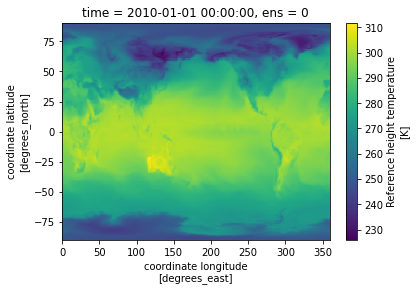

In [14]:
#force coordinate variables to match
ds_atm['lat'] = ds['lat']
ds_atm['lon'] = ds['lon']
ds_atmSSP['lat'] = dsSSP['lat']
ds_atmSSP['lon'] = dsSSP['lon']

for i in range(len(atm_vars)):
    ds[atm_vars[i]] = ds_atm[atm_vars[i]]
    dsSSP[atm_vars[i]] = ds_atmSSP[atm_vars[i]]

ds[atm_vars[0]].isel(ens=0,time=0).plot();   

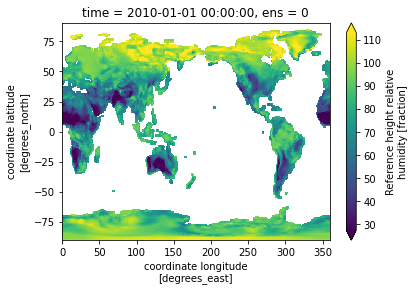

In [15]:
# sum rain + snow for precip.
s2d = 3600 * 24  # convert from sec to day
ds['PPT'] = (ds['RAIN']+ds['SNOW'])*s2d
ds.PPT.attrs['units'] = 'mm/d'
ds.PPT.attrs['long_name'] = 'Total Precip.'

dsSSP['PPT'] = (dsSSP['RAIN']+dsSSP['SNOW'])*s2d
dsSSP.PPT.attrs['units'] = 'mm/d'
dsSSP.PPT.attrs['long_name'] = 'Total Precip'

# mask out oceans for temp and RH
ds = ds.where(ds['PPT'].max(['time','ens'])> 0.)
dsSSP = dsSSP.where(dsSSP['PPT'].max(['time','ens'])> 0.)
ds['RHREFHT'].isel(time=0,ens=0).plot(robust=True);

In [16]:
%%time
# convert units as needed
ds['temp'] = ds['TREFHT'] - 273.15     # convert to degC
ds['tmax'] = ds['TREFHTMX'] - 273.15   # convert to degC
ds['rh'] = ds['RHREFHT']/100           # convert to fraction
ds['rh'] = ds['rh'].where(ds.rh<1,1)   # set max rh=1
ds['wind'] = ds['WSPDSRFAV']*3600*1e-3 # convert m/s to km/h
ds['temp'].attrs['units'] = 'degC'
ds['tmax'].attrs['long_name'] = ds['TREFHTMX'].attrs['long_name']
ds['tmax'].attrs['units'] = 'degC'
ds['wind'].attrs['long_name'] = ds['WSPDSRFAV'].attrs['long_name']
ds['wind'].attrs['units'] = 'km/h'

dsSSP['temp'] = dsSSP['TREFHT'] - 273.15      # convert to degC
dsSSP['tmax'] = dsSSP['TREFHTMX'] - 273.15    # convert to degC
dsSSP['rh'] = dsSSP['RHREFHT']/100            # convert to fraction
dsSSP['rh'] = dsSSP['rh'].where(dsSSP.rh<1,1) # set max rh=1
dsSSP['wind'] = dsSSP['WSPDSRFAV']*3600*1e-3  # convert m/s to km/h
dsSSP['temp'].attrs['units'] = 'degC'
dsSSP['tmax'].attrs['long_name'] = ds['TREFHTMX'].attrs['long_name']
dsSSP['tmax'].attrs['units'] = 'degC'
dsSSP['wind'].attrs['long_name'] = ds['WSPDSRFAV'].attrs['long_name']
dsSSP['wind'].attrs['units'] = 'km/h'

# mask out missing values (again) & compute data
ds = ds.where(ds['PPT'].max(['time','ens'])> 0.)#.compute(skipna=True)
dsSSP = dsSSP.where(dsSSP['PPT'].max(['time','ens'])> 0.)#.compute(skipna=True)

CPU times: user 87.3 ms, sys: 0 ns, total: 87.3 ms
Wall time: 85.6 ms


--------------
## Calculate Nesterov Fire Danger Index
- acc_NI is the accumulated Nesterov fire danger index, which resets w/ daily precip > 3 mm 
- d_NI is the daily Nesterov fire danger index, calculated from temp, precip & RH
- from https://github.com/NGEET/fates/blob/master/fire/SFMainMod.F90

  - temp  = TREFHT (in C)
  - ppt   = PPT*sec_per_day (mm)
  - rh    = RHREFHT (fraction)
   
Nesterov Fire danger Index code in FATES: https://github.com/NGEET/fates/blob/8827a6ea77f0e4f5d8408ddd7eeaa776bb3bba8a/fire/SFMainMod.F90#L116-L162


CPU times: user 332 ms, sys: 22.4 ms, total: 354 ms
Wall time: 4.31 s


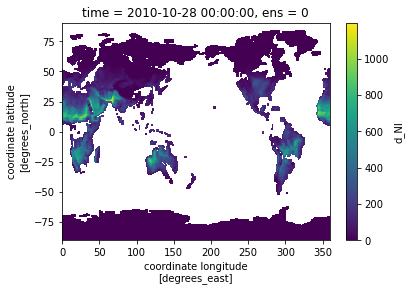

In [17]:
%%time
# these are the calculations that take forever!
# maybe it's not worth loading thse intermediate calculations into memory?  

# Fates_fire constants
# Nesterov from EQ 5 Thonicke et al 2010:
fdi_a = 17.62 
fdi_b = 243.12

yipsolon = (fdi_a* ds.temp)/(fdi_b+ ds.temp)+np.log(ds.rh) 
yipsolonSSP = (fdi_a* dsSSP.temp)/(fdi_b+ dsSSP.temp)+np.log(dsSSP.rh) 

#Standard met. formula
dewpoint = (fdi_b*yipsolon)/(fdi_a-yipsolon)
dewpointSSP = (fdi_b*yipsolonSSP)/(fdi_a-yipsolonSSP)

#follows Nesterov 1968.  Equation 5. Thonicke et al. 2010.
ds['d_NI'] = ((ds.temp-dewpoint)* ds.temp)#.compute(skipna=True) 
dsSSP['d_NI'] = ((dsSSP.temp-dewpointSSP)* dsSSP.temp)

# don't allow negative values
ds['d_NI'] = ds['d_NI'].where(ds['d_NI']>0,0)  
dsSSP['d_NI'] = dsSSP['d_NI'].where(dsSSP['d_NI']>0,0)  

# Reset when daily precip > 3 mm/day 
ds['d_NI'] = ds['d_NI'].where(ds.PPT<3,np.nan)#.compute(skipna=True)
dsSSP['d_NI'] = dsSSP['d_NI'].where(dsSSP.PPT<3,np.nan)#.compute(skipna=True)
ds['d_NI'].isel(ens=0,time=300).plot() ;

### Accumulate Nesterov index over the fire season
####  Reset when daily precip > 3 mm/day (set d_NI to nan) 

In [18]:
# faster to select grid here
plat, plon =   -13,307.5
# 66.4, 209 Alaska      
# 39,253    Crested Butte     
#-13,307.5  Jackies amazon point
#40, 270     

In [19]:
# reset cumulative sum when nan crossed in dataset
# pandas examples here https://stackoverflow.com/questions/18196811/cumsum-reset-at-nan seems to work, 
#    not so much for the numpy example...

# define function that calculates cumulative sum of d_NI that resets when nan
def runningSum(dIN):
    # make array to hold data
    result = dIN.copy()

    # loop over ens
    ## Can we avoind the ens loop here?
    for i in range(len(result[:])):
        v = pd.Series(dIN[i])
        cumsum = v.cumsum().fillna(method='pad')
        reset = -cumsum[v.isnull()].diff().fillna(cumsum)
        result[i,:] = v.where(v.notnull(), reset).cumsum()
        
    return result

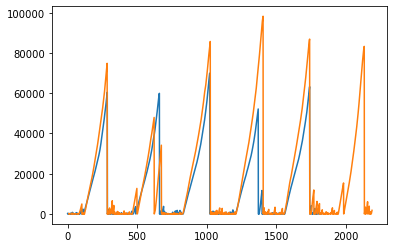

In [20]:
# test for a single grid
# data must be loaded into memory to work in the function above
tempIn = ds['d_NI'].sel(lon=plon, lat=plat, method='nearest').copy(deep=True).load()
tempInSSP = dsSSP['d_NI'].sel(lon=plon, lat=plat, method='nearest').copy(deep=True).load()

temp = runningSum(tempIn)
tempSSP = runningSum(tempInSSP)
plt.plot(temp[0,:])
plt.plot(tempSSP[0,:]) ;

### Now try over full grid
Must load into memory first

In [21]:
%%time 
ds['d_NI'].load()
print('finished loading data')

finished loading data
CPU times: user 2.62 s, sys: 19.8 s, total: 22.4 s
Wall time: 1min 7s


In [22]:
%%time
# use apply_ufunc to broadcast runningSum function globally
ntime = ds['d_NI'].sizes['time']
TEST = xr.apply_ufunc(runningSum, ds['d_NI'],
                        input_core_dims=[['ens','time']],
                        output_core_dims=[['ens',"time"]],
                        vectorize=True,
                        keep_attrs=True,
                        dask="parallelized",
                        #output_dtypes=['float64'],#[np.float],
                        #output_sizes={"ens": nens, 'time': ntime},
                        )
print('finished acc_NI, hist')

finished acc_NI, hist
CPU times: user 7min 48s, sys: 12.2 s, total: 8min
Wall time: 8min 43s


### Can this be done more efficiently?  

DataArrayGroupBy, grouped over 'year' 
5 groups with labels 2010, 2011, 2012, 2013, 2014.
DataArrayResample, grouped over '__resample_dim__' 
5 groups with labels 2010-12-31, 00:00:00, ..., 201....


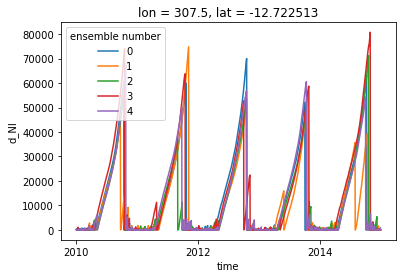

In [23]:
# quick look at the data
TEST.sel(lat=plat,lon=plon, method='nearest').plot(hue='ens');
print(TEST.groupby('time.year'))
print(TEST.resample(time='Y',skipna=True) )#.count(dim='time') )

## NI Fire Risk classification
* 0-300 minimal danger
* to 1000 moderate
* to 4000 high
* above 4000 extreme

In [26]:
%%time
# Ensemble mean of days / year with extreme fire risk
exCount = TEST.where(TEST>4000).resample(time='Y',skipna=True).count(dim='time').mean(dim='ens').compute(skipna=True)
exCountstd = TEST.where(TEST>4000).resample(time='Y',skipna=True).count(dim='time').std(dim='ens').compute(skipna=True)

CPU times: user 11.3 s, sys: 42.7 s, total: 54.1 s
Wall time: 2min 54s


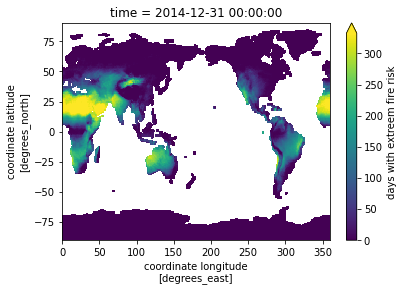

In [27]:
exCount.where(ds['PPT'].max(['time','ens'])> 0.).isel(time=-1).plot(robust=True, 
                                             cbar_kwargs={"label": "days with extreem fire risk"}) ;

### Repeat with SSP data

In [28]:
%%time
dsSSP['d_NI'].load()
# use apply_ufunc to broadcast runningSum function globally
ntime = dsSSP['d_NI'].sizes['time']
TESTSSP = xr.apply_ufunc(runningSum, dsSSP['d_NI'],
                        input_core_dims=[['ens','time']],
                        output_core_dims=[['ens',"time"]],
                        vectorize=True,
                        keep_attrs=True,
                        dask="parallelized",
                        #output_dtypes=['float64'],#[np.float],
                        #output_sizes={"ens": nens, 'time': ntime},
                        )
print('finished acc_NI, hist')

finished acc_NI, hist
CPU times: user 8min 13s, sys: 38.1 s, total: 8min 52s
Wall time: 11min 5s


In [29]:
%%time
exCountSSP = TESTSSP.where(TESTSSP>4000).resample(time='Y',skipna=True).count(dim='time').mean(dim='ens').compute(skipna=True)
exCountSSPstd = TESTSSP.where(TESTSSP>4000).resample(time='Y',skipna=True).count(dim='time').std(dim='ens').compute(skipna=True)

CPU times: user 14.6 s, sys: 53.6 s, total: 1min 8s
Wall time: 3min 56s


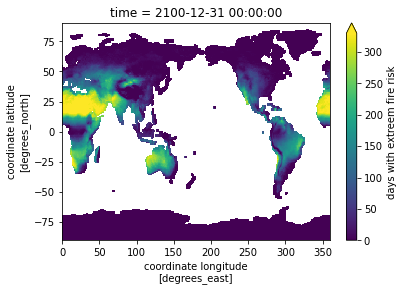

In [30]:
exCountSSP.where(dsSSP['PPT'].max(['time','ens'])> 0.).isel(time=-1).plot(robust=True,
                                             cbar_kwargs={"label": "days with extreem fire risk"}) ;

## Change days with in extreme fire risk 

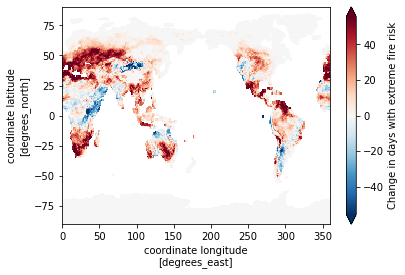

In [31]:
(exCountSSP.isel(time=-1)-exCount.isel(time=-1)).where(
    dsSSP['PPT'].max(['time','ens'])> 0).plot(robust=True,
                                             cbar_kwargs={"label": "Change in days with extreme fire risk"}) ;

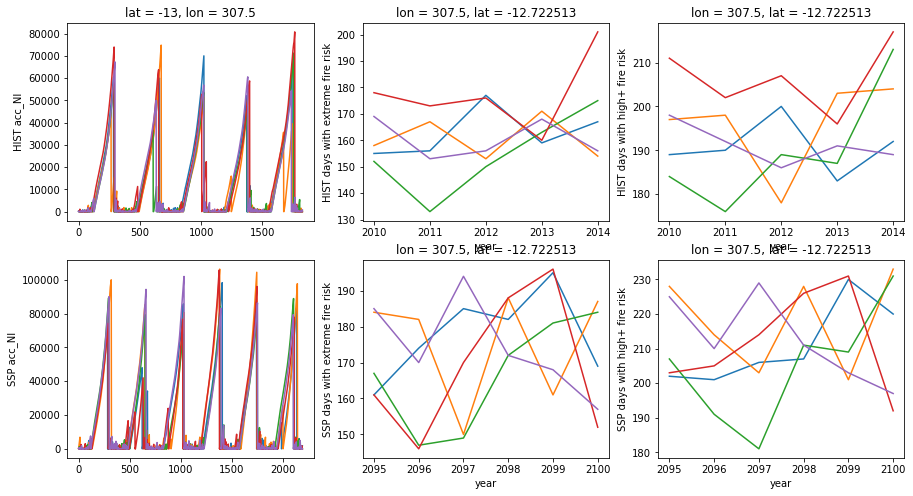

In [32]:
plt.figure(figsize=[15,8])
plt.subplot(2,3,1)
plt.plot(temp.transpose('time','ens')); 
plt.title('lat = '+str(plat)+', lon = '+str(plon))
plt.ylabel('HIST acc_NI');

plt.subplot(2,3,2)
exCount = temp.where(temp>4000).groupby('time.year').count(dim='time')
exCount.plot(hue='ens',add_legend=False);
plt.ylabel('HIST days with extreme fire risk');

plt.subplot(2,3,3)
hiCount = temp.where(temp>1000).groupby('time.year').count(dim='time')
hiCount.plot(hue='ens',add_legend=False);
plt.ylabel('HIST days with high+ fire risk');

plt.subplot(2,3,4)
plt.plot(tempSSP.transpose('time','ens')); 
plt.ylabel('SSP acc_NI');

plt.subplot(2,3,5)
exCount = tempSSP.where(tempSSP>4000).groupby('time.year').count(dim='time')
exCount.plot(hue='ens',add_legend=False);
plt.ylabel('SSP days with extreme fire risk');

plt.subplot(2,3,6)
hiCount = tempSSP.where(tempSSP>1000).groupby('time.year').count(dim='time')
hiCount.plot(hue='ens',add_legend=False);
plt.ylabel('SSP days with high+ fire risk');

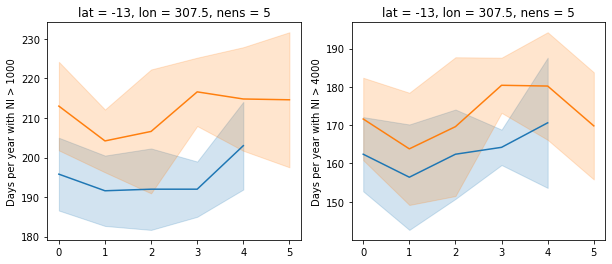

In [33]:
plt.figure(figsize=[10,4])
minRisk = [1000,4000]
for i in range(2):
    exCount_HIST = temp.where(temp>minRisk[i]).groupby('time.year').count(dim='time').mean(dim='ens')
    exCount_HISTsd = temp.where(temp>minRisk[i]).groupby('time.year').count(dim='time').std(dim='ens')
    exCount_SSP = tempSSP.where(tempSSP>minRisk[i]).groupby('time.year').count(dim='time').mean(dim='ens')
    exCount_SSPsd = tempSSP.where(tempSSP>minRisk[i]).groupby('time.year').count(dim='time').std(dim='ens')
    x1 = range(len(exCount_HIST.year))
    x2 = range(len(exCount_SSP.year))
    plt.subplot(1,2,(i+1))
    plt.plot(x1, exCount_HIST)
    plt.plot(x2, exCount_SSP)
    plt.fill_between(x1, exCount_HIST - exCount_HISTsd, exCount_HIST + exCount_HISTsd, 
                    alpha=0.2,color='tab:blue')
    plt.fill_between(x2, exCount_SSP - exCount_SSPsd, exCount_SSP + exCount_SSPsd, 
                    alpha=0.2,color='tab:orange')
    plt.title('lat = '+str(plat)+', lon = '+str(plon)+', nens = '+str(nens))
    plt.ylabel('Days per year with NI > '+str(minRisk[i]));

#plt.plot(exCount_SSP)

### Accumulated Nesterov fire danger index shows increases in the number of days per year with high or extreme fire danger in 2100, relative to 2000, 
- check for statistical significance

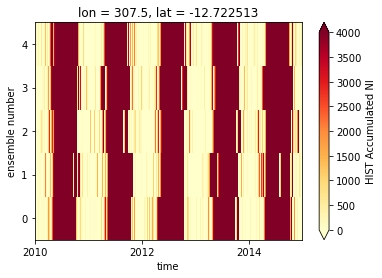

In [34]:
temp.plot(robust=True, cmap='YlOrRd',vmax=4000,vmin=0,
          cbar_kwargs={"label": "HIST Accumulated NI"}) ;

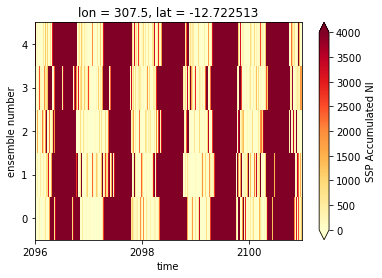

In [35]:
tempSSP.isel(time=slice(365,None)).plot(robust=True, cmap='YlOrRd',vmax=4000,vmin=0,
          cbar_kwargs={"label": "SSP Accumulated NI"}) ;

### Maybe better illustrates seaonal cycle of fire risk, appears to have greater variability by 2100!

-----------------------
# Canadian fire weather model
### based on temp, wind, RH, precip & adjusted for monthly day length by latitude
- **fine fuel mositure code (ffmc)**: calc_ffmc(tempC, wind_kmhr, RH, precip_mm, ffmc_prev):
- **duff moisture code (dmc)**: calc_dmc(tmaxC, RH, precip_mm, dmc_prev, month, latitude):
- **drought code (dc)**: calc_dc(tmaxC, precip_mm, dc_prev, month, latitude):
- **initial spread index (isi)**: calc_isi(wind_kmhr,ffmc):
- **build up index (bui)**: calc_bui(dmc,dc):
- **fire weather index (fwi)**: calc_fwi(isi,bui) 

In [43]:
plat, plon = 66.4, 209
# 66.4, 209 Alaska      
# 39,253    Crested Butte     
#-13,307.5  Jackie's amazon point
#40, 270  
tempDS = ds.sel(ens=0,lon=plon, lat=plat, method='nearest').load()
tempSSP = dsSSP.sel(ens=0,lon=plon, lat=plat, method='nearest').load()

In [44]:
#tempDS.tmax.values[0]
tempDS['RHREFHT'] = tempDS.RHREFHT.where(tempDS.RHREFHT<100,100)
tempSSP['RHREFHT']  = tempSSP.RHREFHT.where(tempSSP.RHREFHT<100,100)
fwi.calc_ffmc(tempDS.tmax.values[3], tempDS.wind.values[3], tempDS.rh.values[3], tempDS.PPT.values[3],80)

82.61578121102278

In [45]:
print(tempDS.tmax.coords)

Coordinates:
    lon      float32 208.8
    lat      float32 66.44
  * time     (time) object 2010-01-01 00:00:00 ... 2014-12-31 00:00:00
    ens      int64 0


In [46]:
%%time
# create arrays to store output
FWIvars = ['ffmc','dmc','dc','isi','bui','fwi']
for v in range(len(FWIvars)):
    tempDS[FWIvars[v]]  = xr.DataArray(np.nan, coords=tempDS.tmax.coords)
    tempSSP[FWIvars[v]] = xr.DataArray(np.nan, coords=tempSSP.tmax.coords)

# loop over days to calculte FWI
for i in range(len(tempDS.tmax)):
    # set initial values for
    if i == 0: 
        ffmc_prev, ffmc_ssp = 80, 80
        dmc_prev,  dmc_ssp  = 6,  6
        dc_prev,   dc_ssp   = 15, 15
    else: 
        ffmc_prev, ffmc_ssp = tempDS['ffmc'].values[(i-1)], tempSSP['ffmc'].values[(i-1)]
        dmc_prev,  dmc_ssp  = tempDS['dmc'].values[(i-1)],  tempSSP['dmc'].values[(i-1)]
        dc_prev,   dc_ssp   = tempDS['dc'].values[(i-1)],   tempSSP['dc'].values[(i-1)]

    # calc_ffmc(tempC, wind_kmhr, RH, precip_mm, ffmc_prev):
    tempDS.ffmc[i] = fwi.calc_ffmc(tempDS.tmax.values[i], tempDS.wind.values[i], 
                                   tempDS.RHREFHT.values[i], tempDS.PPT.values[i],ffmc_prev)
    tempSSP.ffmc[i] = fwi.calc_ffmc(tempSSP.tmax.values[i], tempSSP.wind.values[i], 
                                    tempSSP.RHREFHT.values[i], tempSSP.PPT.values[i],ffmc_ssp)
    # calc_dmc(tmaxC, RH, precip_mm, dmc_prev, month, latitude):
    tempDS.dmc[i] = fwi.calc_dmc(tempDS.tmax.values[i],  tempDS.RHREFHT.values[i],   
                                 tempDS.PPT.values[i], dmc_prev, 
                                 tempDS['time.month'][i], tempDS['lat'])
    tempSSP.dmc[i] = fwi.calc_dmc(tempSSP.tmax.values[i], tempSSP.RHREFHT.values[i], 
                                  tempSSP.PPT.values[i], dmc_ssp,
                                  tempDS['time.month'][i], tempDS['lat'])
    # calc_dc(tmaxC, precip_mm, dc_prev, month, latitude):
    tempDS.dc[i] = fwi.calc_dc(tempDS.tmax.values[i], tempDS.PPT.values[i], dc_prev, 
                                 tempDS['time.month'][i], tempDS['lat'])
    tempSSP.dc[i] = fwi.calc_dc(tempSSP.tmax.values[i], tempSSP.PPT.values[i], dc_ssp,
                                  tempDS['time.month'][i], tempDS['lat'])
    # calc_isi(wind_kmhr,ffmc):
    tempDS.isi[i]  = fwi.calc_isi(tempDS.wind[i], tempDS.ffmc[i] )
    tempSSP.isi[i] = fwi.calc_isi(tempSSP.wind[i],tempSSP.ffmc[i])
    # calc_bui(dmc,dc):
    tempDS['bui'][i]  = fwi.calc_bui(tempDS.dmc[i], tempDS.dc[i] )
    tempSSP['bui'][i] = fwi.calc_bui(tempSSP.dmc[i],tempSSP.dc[i])
    # calc_fwi(isi,bui): 
    tempDS['fwi'][i]  = fwi.calc_fwi(tempDS.isi[i], tempDS.bui[i])
    tempSSP['fwi'][i] = fwi.calc_fwi(tempSSP.isi[i],tempSSP.bui[i])

print('finished FWI calculations')

finished FWI calculations
CPU times: user 1min 19s, sys: 498 ms, total: 1min 19s
Wall time: 1min 19s


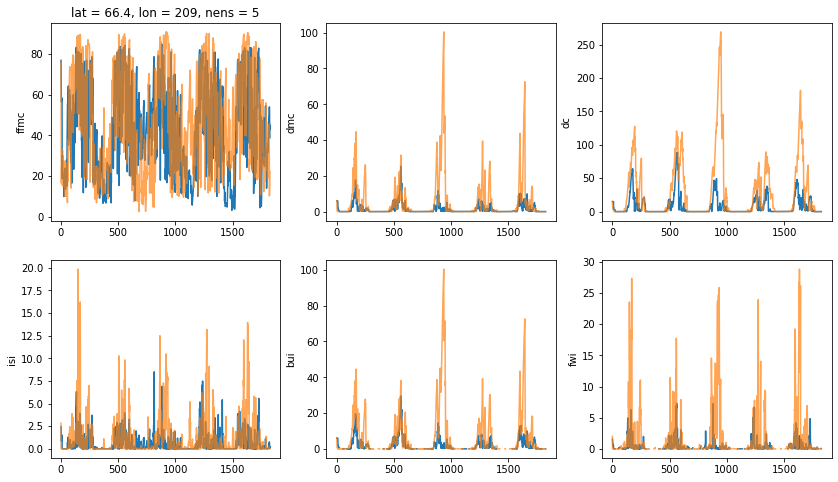

In [47]:
plt.figure(figsize=[14,8])
for i in range(len(FWIvars)):
    plt.subplot(2,3,(i+1))
    if i == 0:
        plt.title('lat = '+str(plat)+', lon = '+str(plon)+', nens = '+str(nens))
    plt.plot(tempDS[FWIvars[i]])
    plt.plot(tempSSP[FWIvars[i]], alpha=0.7)
    plt.ylabel(FWIvars[i]);

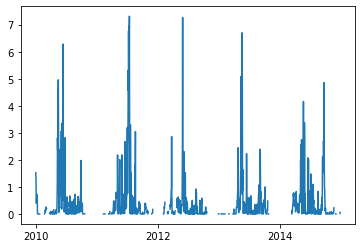

In [48]:
plt.plot(tempDS.time, tempDS['fwi']) ;
#plt.plot(tempSSP['fwi'])

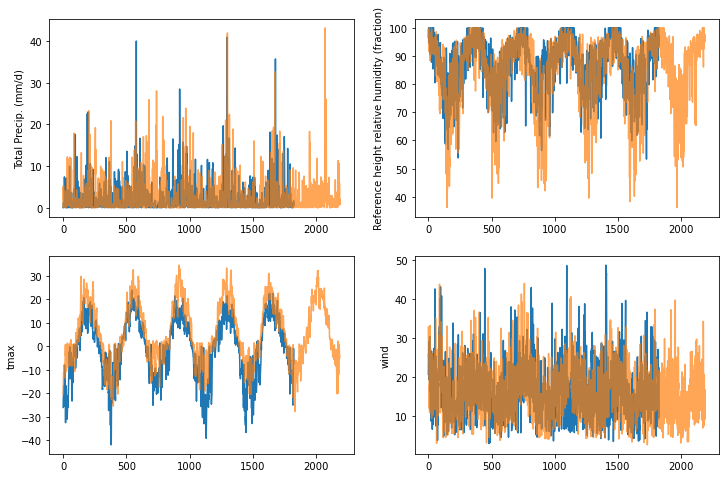

In [49]:
atmVARS = ['PPT','RHREFHT','tmax','wind']
plt.figure(figsize=[12,8])

for i in range(len(atmVARS)):
    plt.subplot(2,2,(i+1))
    plt.plot(tempDS[atmVARS[i]])
    plt.plot(tempSSP[atmVARS[i]], alpha=0.7) 
    if i <2:
        plt.ylabel(tempDS[atmVARS[i]].attrs['long_name']+' ('+
               tempDS[atmVARS[i]].attrs['units']+')' ) 
    else:
        plt.ylabel(atmVARS[i]) ; 